# AllLife Credit Card Customer Segmentation

## Background

AllLife Bank wants to focus on its credit card customer base in the next
financial year. They have been advised by their marketing research team, that the
penetration in the market can be improved. Based on this input, the Marketing team
proposes to run personalised campaigns to target new customers as well as upsell to
existing customers. Another insight from the market research was that the customers
perceive the support services of the back poorly. Based on this, the Operations team
wants to upgrade the service delivery model, to ensure that customers queries are
resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the
Data Science team for help.

### Objective

To identify different segments in the existing customer based on their
spending patterns as well as past interaction with the bank. 

### Import Libraries

In [1]:
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(color_codes=True) # adds a nice background to the graphs

### Load Dataset

In [264]:
credit_card_df = pd.read_excel('Credit Card Customer Data.xlsx')
credit_card_df.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


Dropping `Sl_No` column because it is not a valid dimension to cluster with

In [265]:
credit_card_df = credit_card_df.drop(columns=['Sl_No', 'Customer Key'])
credit_card_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [266]:
credit_card_df.shape

(660, 5)

660 rows and 6 columns

In [267]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [268]:
credit_card_df.isnull().values.any()

False

### Univariate Analysis

**Distribution Plots**

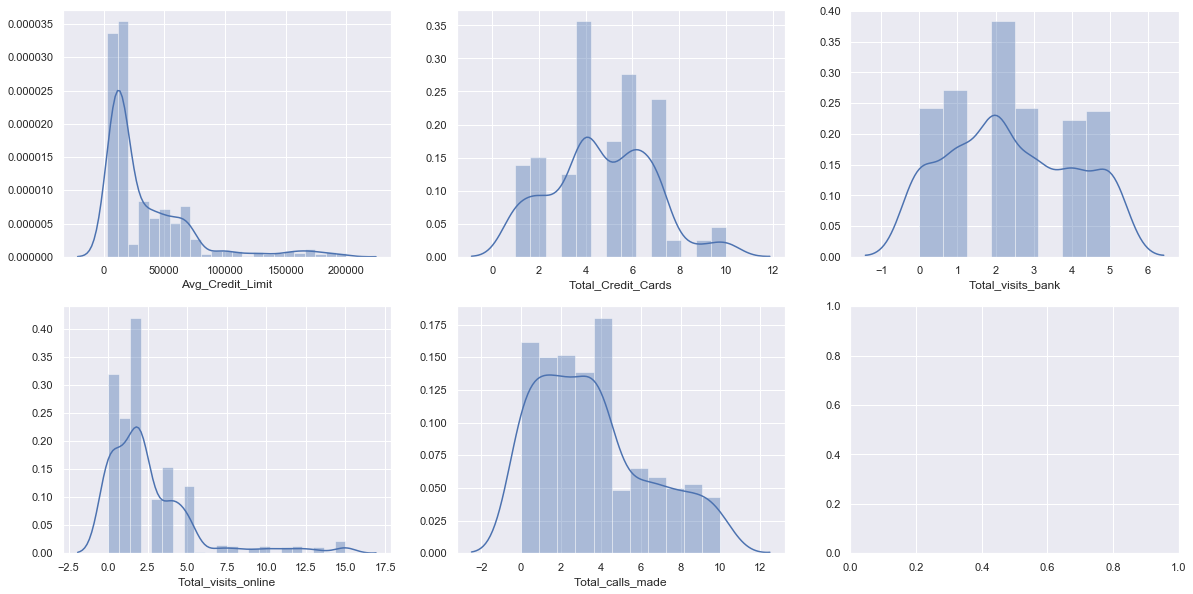

In [269]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

for i, column in enumerate(credit_card_df.columns):
    sns.distplot(credit_card_df[column], ax=axes[i//3,i%3]);
    
plt.show()

**Box Plots**

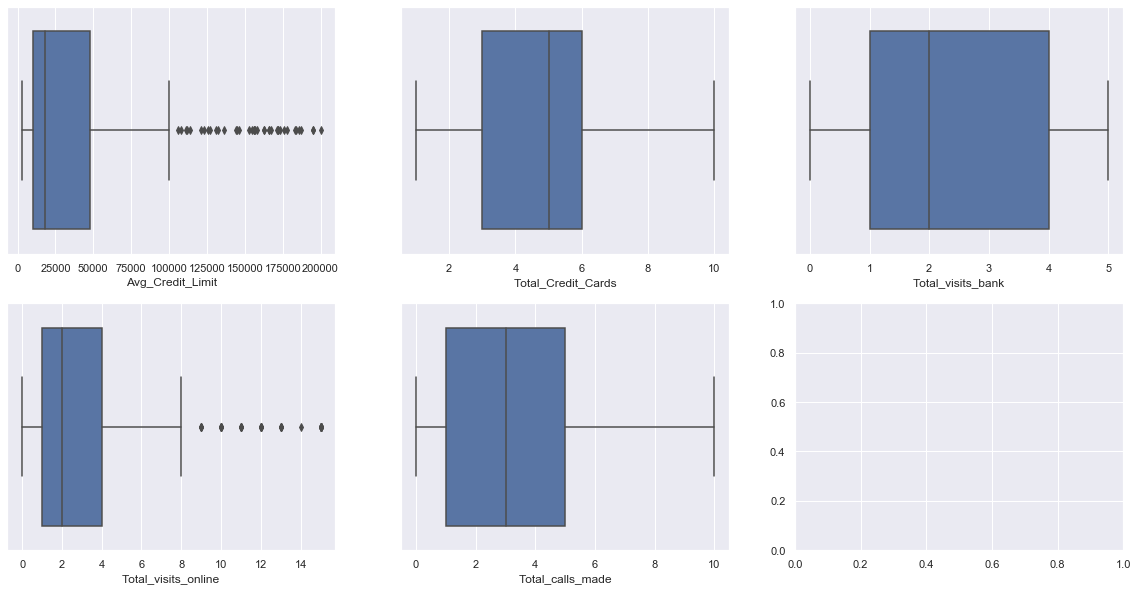

In [270]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

for i, column in enumerate(credit_card_df.columns):
    sns.boxplot(credit_card_df[column], ax=axes[i//3,i%3]);
    
plt.show()

**Observations:**
    
- The `Avg_Credit_Limit` column is left skewed and it looks like there a lot of records with values around 0
- The `Total_Credit_Cards` column looks almost like a normal distribution but it looks like there are some categories being shown from that column
- The `Total_visits_bank` column also shows some distinction between customers
- The `Total_visits_online` column is also heavily left skewed and it looks like there are some outliers on the right
- The `Total_calls_made` column is also left skewed but a little more balanced out with less obvious outliers

### Bivariate Analysis

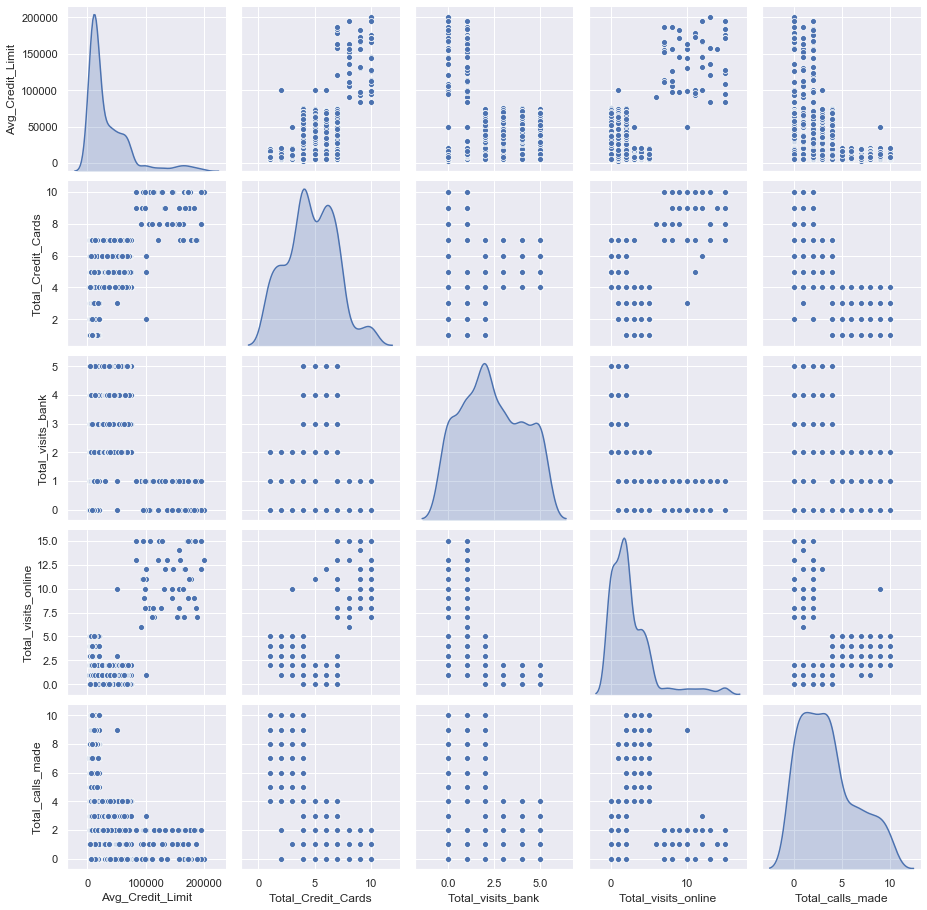

In [11]:
sns.pairplot(credit_card_df,diag_kind='kde');

**Observations**

- No linear relationship between variables
- Some clusters are becoming visible from the cros scatter plots

### Preprocess Data

#### Handle outliers

In [12]:
loged_df = credit_card_df.copy()
loged_df['Avg_Credit_Limit'] = np.log(credit_card_df['Avg_Credit_Limit'])
loged_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,11.512925,2,1,1,0
1,10.819778,3,0,10,9
2,10.819778,7,1,3,4
3,10.308953,5,1,1,4
4,11.512925,6,0,12,3


#### Scale

In [260]:
from scipy.stats import zscore

scaled_df = loged_df.apply(zscore)
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-0.547490,-1.251537
1,0.885387,-0.787585,-1.473731,2.520519,1.891859
2,0.885387,1.058973,-0.860451,0.134290,0.145528
3,0.336281,0.135694,-0.860451,-0.547490,0.145528
4,1.630478,0.597334,-1.473731,3.202298,-0.203739


## K-Means Clustering

In [261]:
from sklearn.cluster import KMeans

cluster_errors = []

for num_clusters in range(1,15):
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(scaled_df)
    
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,3300.000000
1,2,1980.654971
2,3,1090.350994
3,4,860.748318
4,5,775.802835
5,6,697.695144
6,7,634.302270
7,8,599.381218
8,9,572.549608
9,10,544.762989


### Find best value for K using Elbow plot

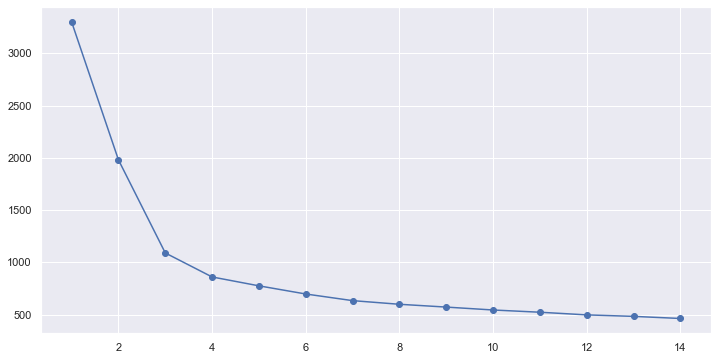

In [262]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o");

The elbow looks like it's at 3 clusters

In [271]:
kmeans = KMeans(n_clusters=3, n_init=5, random_state=1)
kmeans.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [272]:
kmeans_labeled_df = scaled_df.copy()
kmeans_labeled_df['label'] = kmeans.labels_
kmeans_labeled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,label
0,1.630478,-1.249225,-0.860451,-0.547490,-1.251537,1
1,0.885387,-0.787585,-1.473731,2.520519,1.891859,0
2,0.885387,1.058973,-0.860451,0.134290,0.145528,1
3,0.336281,0.135694,-0.860451,-0.547490,0.145528,1
4,1.630478,0.597334,-1.473731,3.202298,-0.203739,2


In [119]:
label_group = kmeans_labeled_df.groupby(['label'])

label_group.agg(['count'])

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
,count,count,count,count,count
label,,,,,
0,225,225,225,225,225
1,385,385,385,385,385
2,50,50,50,50,50


#### Visualize cluster

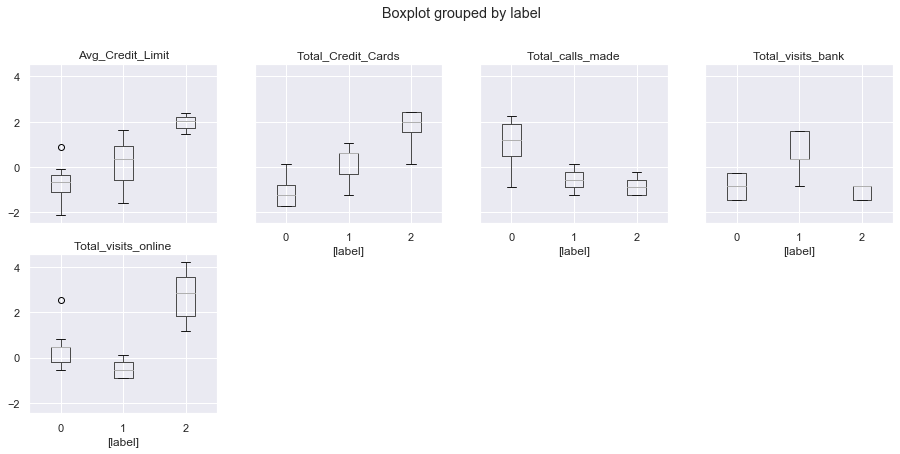

In [120]:
kmeans_labeled_df.boxplot(by='label', layout=(3,4), figsize=(15, 10));

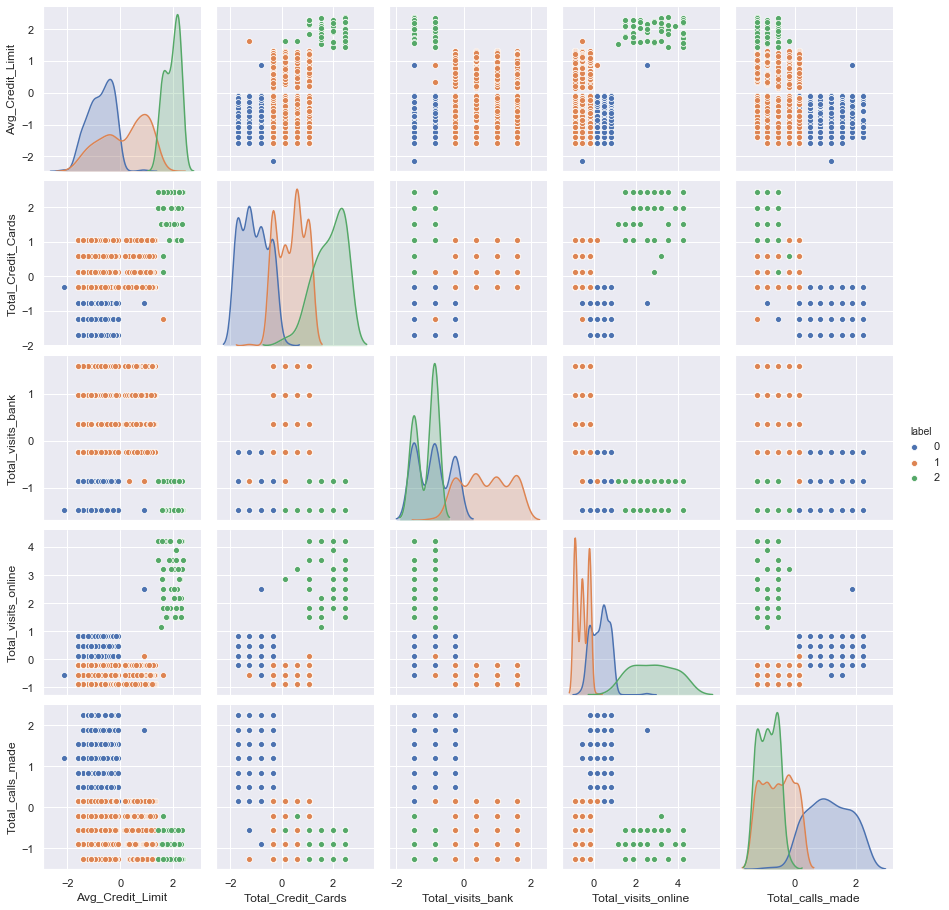

In [121]:
sns.pairplot(kmeans_labeled_df,diag_kind='kde', hue='label');

## Hierarchical Clustering

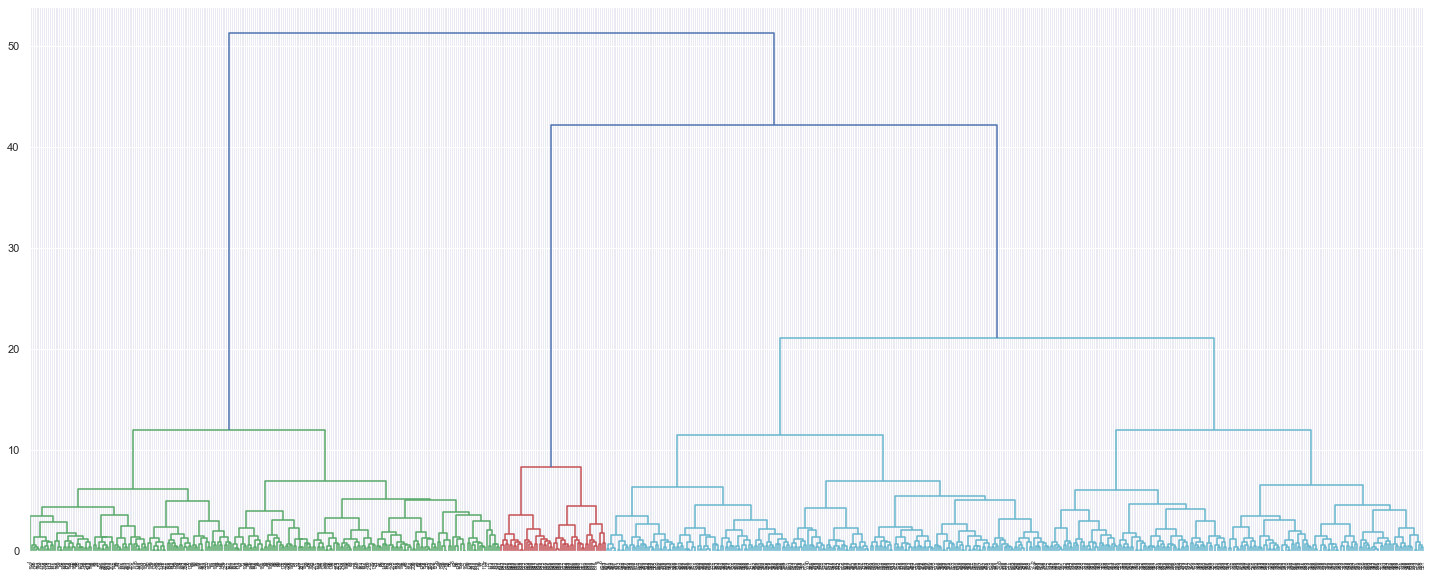

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

ward_Z = linkage(scaled_df, method='ward', metric='euclidean')

plt.figure(figsize=(25, 10))
dn = dendrogram(ward_Z)
plt.show()

In [169]:
from scipy.spatial.distance import pdist
coeff, _ = cophenet(ward_Z, pdist(scaled_df, metric='euclidean'))
coeff

0.7464670063107975

### Test different linkage methods performance with euclidean distance using Cophenetic correlation coefficient

In [233]:
methods = ['single', 'complete', 'weighted', 'centroid', 'median', 'ward']

for method in methods:
    Z = linkage(scaled_df, method=method, metric='euclidean')
    coeff, _ = cophenet(
        Z, 
        pdist(scaled_df, metric='euclidean')
    )
    print((method, coeff))

('single', 0.6935695421676707)
('complete', 0.8380834753160014)
('weighted', 0.862707055499893)
('centroid', 0.86841254357499)
('median', 0.8591211874947847)
('ward', 0.7464670063107975)


We'll use the the centroid method because it has the highest cophenetic correlation coefficient

#### Truncate dendrogram and get optimal distance

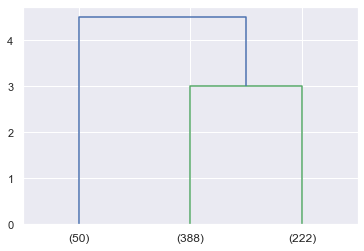

In [236]:
centroid_Z = linkage(scaled_df, method='centroid', metric='euclidean')
dendrogram(
    centriod_Z,
    truncate_mode='lastp',
    p=3,  
);

In [237]:
max_d = 2.99

In [239]:
from scipy.cluster.hierarchy import fcluster
hierarchical_clusters = fcluster(centriod_Z, max_d, criterion='distance')
len(set(hierarchical_clusters))

3

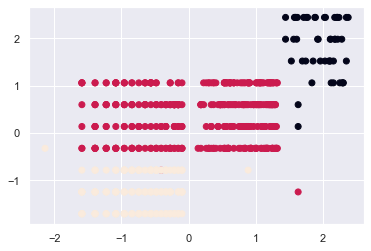

In [240]:
plt.scatter(scaled_df.iloc[:,0], scaled_df.iloc[:,1], c=hierarchical_clusters)  # plot points with cluster dependent colors
plt.show()

### Agglomerative Clustering

In [243]:
from sklearn.cluster import AgglomerativeClustering
agglo_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
agglo_model.fit(scaled_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [246]:
set(agglo_model.labels_)

{0, 1, 2}

In [247]:
hierarchical_labeled_df = scaled_df.copy()
hierarchical_labeled_df['label'] = hierarchical_clusters

#### Visualize clusters

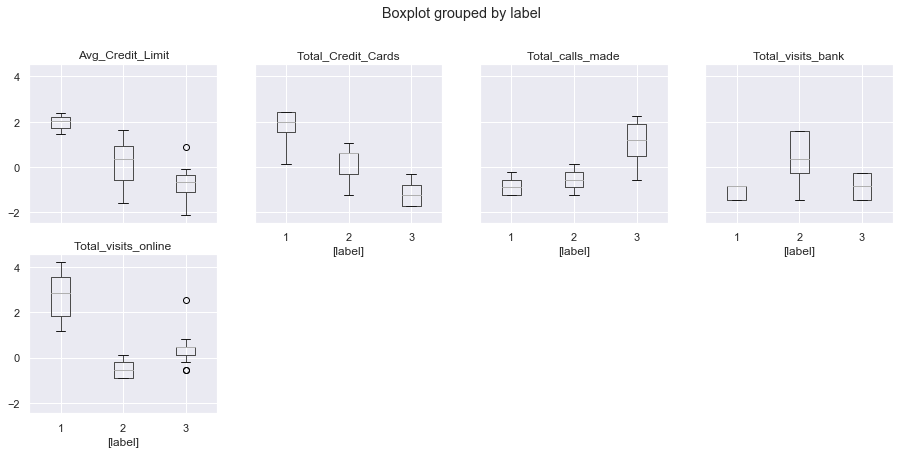

In [248]:
hierarchical_labeled_df.boxplot(by='label', layout=(3,4), figsize=(15, 10));

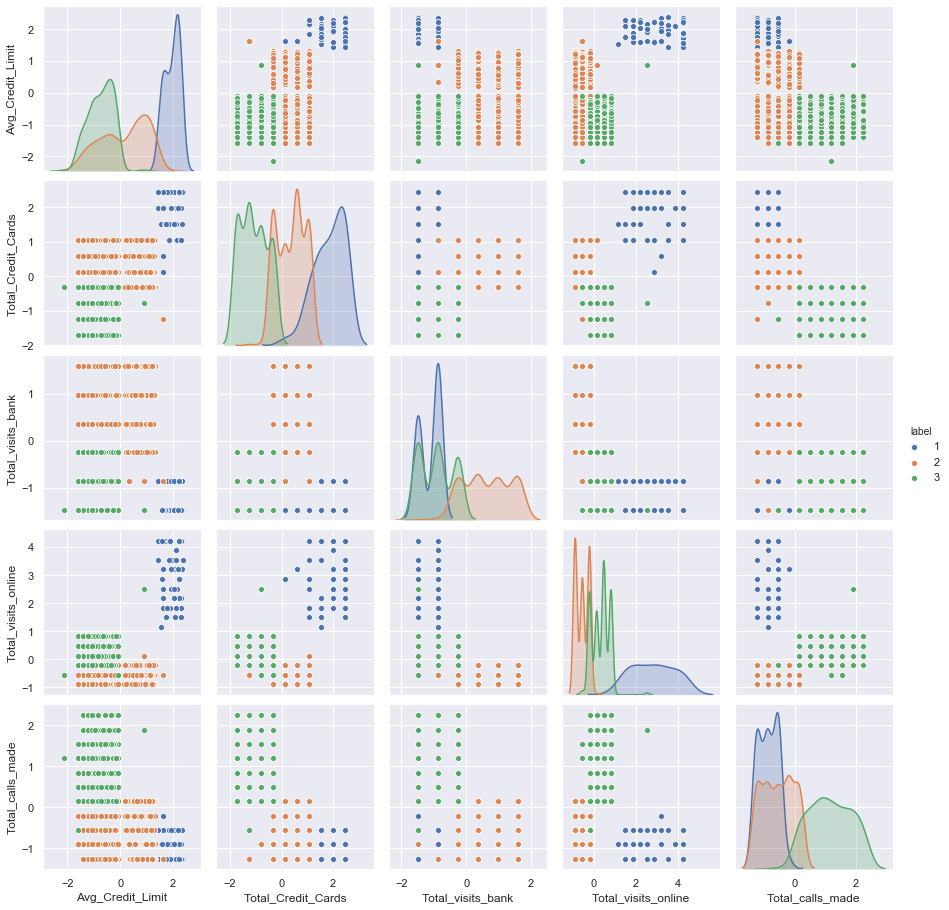

In [249]:
sns.pairplot(hierarchical_labeled_df,diag_kind='kde', hue='label');

## Silhouette Scores

In [257]:
### Divisive clustering

from sklearn.metrics import silhouette_score

silhouette_score(scaled_df, hierarchical_clusters, metric='euclidean')

0.49282785670224116

In [258]:
# Agglomerative clustering

silhouette_score(scaled_df, agglo_model.labels_, metric='euclidean')

0.492940751274099

In [259]:
# Kmeans clustering

silhouette_score(scaled_df, kmeans.labels_, metric='euclidean')

0.4930010449995642

Kmeans clustering has a slightly better silhouette score than Hierachical Clustering techniques for this use case

### Answers to key questions

**How many different segments of customers are there?**

There are 3 main customer segments

**How are these segments different from each other?**

Here are some observations about categories from the last pair plot:

- **Category 1:** Customers in this category have the highest average credit limit and own more credit cards than customers in other categories. They visit the bank the least and use online services the most. They also make the least number of calls to the bank. This category has the least number of customers

- **Category 2:** Customer in this category have average credit limits more than those in category 1 but less than those in category 3. They also own less number of credit cards than those in category 1 but more than those in category 3. These customers visit the bank the most and use online services the least. They make less calls to the bank than those in category 1 but a little more than those in category 3. This category has the most number of customers

- **Category 3:** Customers in this have a low average credit limit and own a low number of credit cards. They visit the bank an average number of times but a little more than customers in category 1 and use online services averagely but less often than customers from category 1. They make the most calls to the bank.



**What are your recommendations to the bank on how to better market to and
service these customers?**

- For customers in category 1, the bank can market premium services to them.
- Customers in category 2 might need to be educated about how to use online services and visit the bank less. This would save the bank cost of attending to the customer from a physical location and also help the customer get better service faster.
- The bank might need to market more credit services to customers in category 3 and advise on how to use credit facilities properly.